# Introduction

Movie recommendation systems are widely used in many online platforms like Netflix, Amazon Prime, and Hulu. These systems are designed to provide personalized movie recommendations to users based on their viewing history, ratings, and preferences.

In this notebook, we will be building a movie recommender system using collaborative filtering on the MovieLens dataset. The dataset contains 25 million ratings from 270,000 users for over 62,000 movies. Our goal is to build a system that can predict how a user will rate a movie that they have not seen yet, and recommend the movies with the highest predicted ratings.

We will be using maximum likelihood estimation (MLE) to build our recommendation system. MLE is a commonly used statistical method that estimates the parameters of a statistical model by maximizing the likelihood of the observed data. In our case, the model will be trained on the MovieLens dataset and the parameters will be the user preferences and the movie features.

We will work in an iterative manner, starting with a simple model and then adding more complexity as we go along. The first model would consist of basic bias terms for users and movies, and user-movie interactions. We will then add genre as a feature to the model, and finally we explore the use of cosine similarity and correlation to improve the performance of the model.

This notebook will follow the approach of an EDA and then some data processing as we go along. Followed by the model building and evaluation. For an initial attempt please review the ```EDA_small_dataset.ipynb``` notebook. You will find that a number of experiments that worked for the small dataset will not work for the large dataset. This notebook walks through all the steps taken to make training possible and scalable. 

This notebook is intended for technical people. If you wish to have a view of methods used, mathematical derivations and experiments, this notebook is here for you perusal. If you are a business executive, please review the Movie_Recommender_System_POC.pdf document. This document is intended for a business audience that is interested in the business case, and value such a system can bring to their business. 


Let's get started!

The notebook is structured in the following way:

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Data Processing](#Data-Processing)
3. [Model Building: Biases](#Bias-Model-Building)
4. [Model Evaluation: Biases](#Bias-Model-Evaluation)
5. [Model Building: Biases and Genre's](#Bias-Genre-Model-Building)
6. [Model Evaluation: Biases and Genre's](#Bias-Genre-Model-Evaluation)
7. [Model Building: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Building)
8. [Model Evaluation: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Evaluation)
9. [Results and Conclusion](#Results)




# 1. Exploratory Data Analysis

In [1]:
# import some basic EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
%matplotlib inline

In [2]:
# set the file path to read in the data
filepath = '../data/ml-25m/'
# filepath = '../data/ml-latest-small/' # for debugging

In [3]:
movies = pd.read_csv(filepath + 'movies.csv')
ratings = pd.read_csv(filepath + 'ratings.csv')
tags = pd.read_csv(filepath + 'tags.csv')

In [4]:
# check the data
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# get some basic info about the data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [8]:
# out of curiousity let's covert the timestamp to a datetime object
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [9]:
# what is the datetime of the oldest and latest movie rating?
print(f"Ratings are collected from {str(ratings['datetime'].min())[0:4]} to {str(ratings['datetime'].max())[0:4]}")

Ratings are collected from 1995 to 2019


In [10]:
# count the number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 162541 | Number of movies = 59047


In [11]:
# check how many movies are in the ratings dataframe but not in the movies dataframe
movies_not_in_ratings = movies[~movies['movieId'].isin(ratings['movieId'])]
print('Number of movies in movies but not in ratings: ' + str(movies_not_in_ratings.shape[0]))
print('So there are ' + str(movies_not_in_ratings.shape[0]) + ' movies that have not been rated by any user.')

Number of movies in movies but not in ratings: 3376
So there are 3376 movies that have not been rated by any user.


In [12]:
# discard movies that have not been rated by any user
movies = movies[movies['movieId'].isin(ratings['movieId'])]

In [13]:
# # create a sparse matrix of the ratings and movies that have been rated
# # This has been done for the smaller set during experimentation. It works for the larger set too, but isn't efficient
# ratings_matrix = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
# ratings_matrix.head()

Calculating best minimal value for power law fit


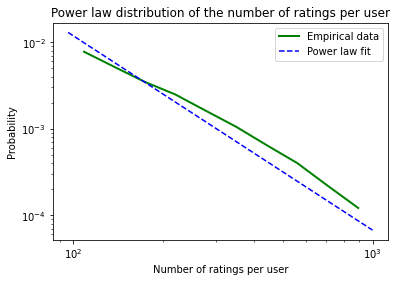

In [14]:
# plot the power law distribution of the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
fit = powerlaw.Fit(ratings_per_user)
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.xlabel('Number of ratings per user')
plt.ylabel('Probability')
plt.title('Power law distribution of the number of ratings per user')
plt.legend(['Empirical data', 'Power law fit'])
plt.show()

In [15]:
# check if there are movies rated 1.5, 2.5, 3.5, 4.5
_check_ratings_increments = ratings['rating'].unique()
print(f'The rating increments are: {sorted(_check_ratings_increments)}')

The rating increments are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Power laws (/Zipf's law) in the data

Based on the power law plot of the rating distribution that we generated earlier, it appears that there is evidence of a power law in the data. A power law is characterized by a straight line on a log-log plot, and the plot we generated does show a linear relationship between the log of the rating values and the log of their corresponding frequency counts.

However, it's important to note that the presence of a power law in a dataset is not always conclusive evidence of a specific underlying mechanism or process. Power laws are often observed in many different types of natural and social phenomena, and it's possible for a dataset to exhibit a power law distribution even if the underlying mechanism is not truly a power law. In addition, the presence of noise or other confounding factors can also affect the accuracy and interpretation of the power law.

To confirm whether the data follows a power law distribution, we perform a goodness-of-fit test, to compare the distribution of the data to a power law distribution.

In [16]:
# perform goodness of fit test
fit.distribution_compare('power_law', 'lognormal')

(-3698.2928651606835, 0.0)

The output of `fit.distribution_compare('power_law', 'lognormal')` is a tuple with two values: the log-likelihood ratio statistic and the p-value of the test.

In this case, the log-likelihood ratio statistic is -3698 and the p-value is 0.

The log-likelihood ratio statistic is a measure of the relative goodness of fit of the two distributions being compared (in this case, a power law distribution and a log-normal distribution). A negative value of the statistic indicates that the power law distribution fits the data better than the log-normal distribution.

The p-value is a measure of the strength of evidence against the null hypothesis, which is that the power law distribution and the log-normal distribution fit the data equally well. A p-value less than 0.05 (or some other pre-specified significance level) indicates that there is strong evidence against the null hypothesis and that the power law distribution fits the data significantly better than the log-normal distribution. (The null hypothesis is that the log-normal distribution is a better fit to the data).

In summary, the output (-3698, 0) suggests that the power law distribution is a significantly better fit to the data than the log-normal distribution, based on the log-likelihood ratio test at a significance level of 0.05.

### Scale free behavior in the data

The presence of the power law in the rating distribution would suggest that the distribution of ratings across movies follows a scale-free pattern. In other words, a few movies would receive a large number of ratings, while the majority of movies would receive relatively few ratings.

Similarly, if a power law distribution is observed in the user activity data, it would suggest that the distribution of user ratings follows a scale-free pattern. This means that a few users would rate a large number of movies, while the majority of users would rate relatively few movies.

The observation of a power law distribution in the ratings data or user activity data could have implications for the design of recommender systems based on this dataset. Specifically, it suggests that a few movies and users have a disproportionately large influence on the overall ratings distribution, and therefore their ratings should be given greater or smaller weight in any recommendation algorithm depending on what we are trying to achieve.

For now, let us continue with our analysis of the data.

<AxesSubplot:xlabel='rating', ylabel='count'>

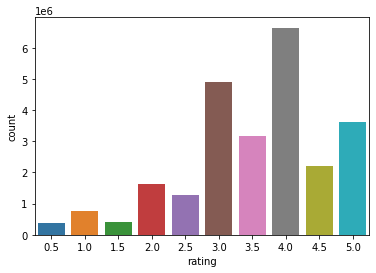

In [17]:
# let's see the distribution of ratings
sns.countplot(x='rating', data=ratings)

In [18]:
# count the number of ratings
ratings['rating'].value_counts().sort_index()

0.5     393068
1.0     776815
1.5     399490
2.0    1640868
2.5    1262797
3.0    4896928
3.5    3177318
4.0    6639798
4.5    2200539
5.0    3612474
Name: rating, dtype: int64

We see that movies tend to be rated more frequently from 3 to 5, while ratings of 1 and 2 are less frequent. This is consistent with the power law plot that we generated earlier.

In [19]:
# let's see how many ratings each user has given
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user.head()

userId
1     70
2    184
3    656
4    242
5    101
Name: rating, dtype: int64

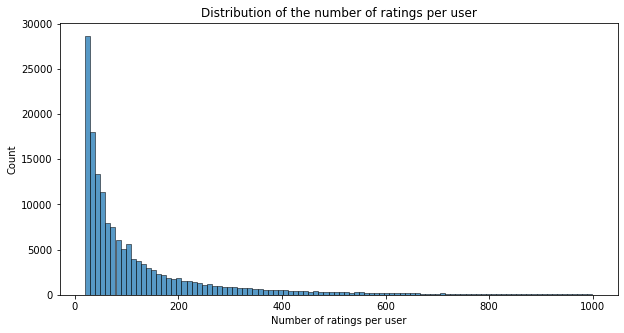

In [20]:
# plot the distribution of the number of ratings per user
# create a dataframe with the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, kde=False, bins=100)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per user')
plt.show()

In [21]:
# let's see how many ratings each movie has received
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.head()

movieId
1    57309
2    24228
3    11804
4     2523
5    11714
Name: rating, dtype: int64

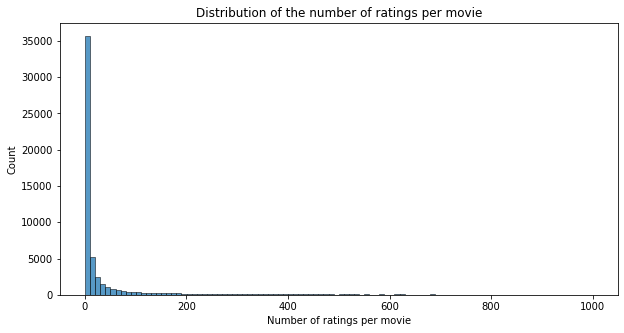

In [22]:
# plot the distribution of the number of ratings per movie
# create a dataframe with the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie[ratings_per_movie < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, kde=False, bins=100)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per movie')
plt.show()

<AxesSubplot:ylabel='None'>

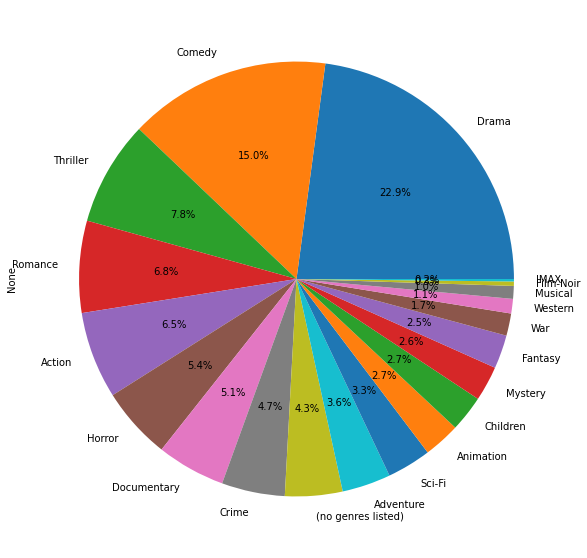

In [23]:
# plot a pie chart of the genres (even though pie charts are not the best way convey information)
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<AxesSubplot:title={'center':'Number of movies in each genre'}, xlabel='Genre', ylabel='Number of movies'>

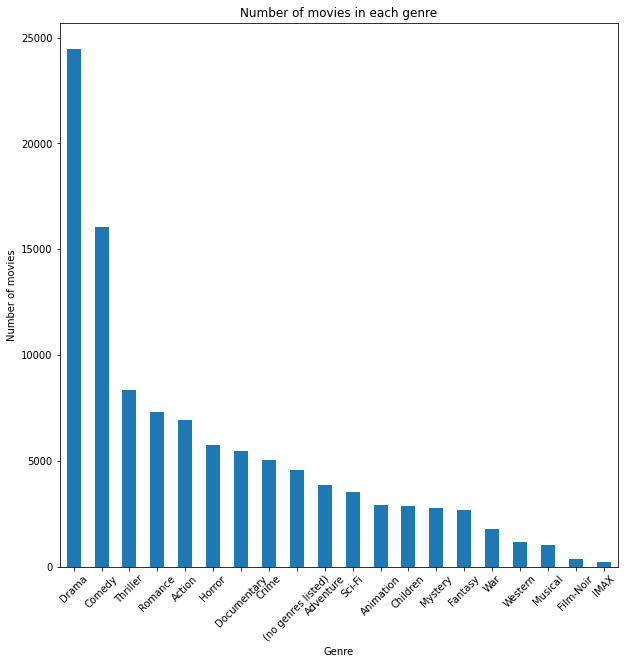

In [24]:
# plot the bar chart of the number of movies in each genre 
# bar charts are much better than pie charts. Propotionally, they are much easier to interpret
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='bar', figsize=(10,10), rot=45, title='Number of movies in each genre', xlabel='Genre', ylabel='Number of movies')


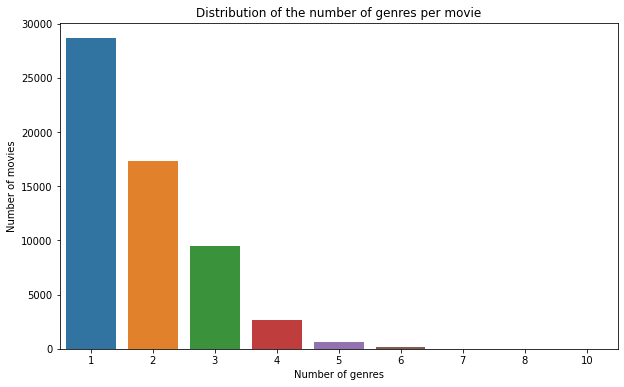

In [25]:
# plot the distribution of the number of genres per movie
movies['num_genres'] = movies['genres'].str.split('|').apply(len)
movies['num_genres'].value_counts()

# plot the distribution of the number of genres per movie
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=movies)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Distribution of the number of genres per movie')
plt.show()

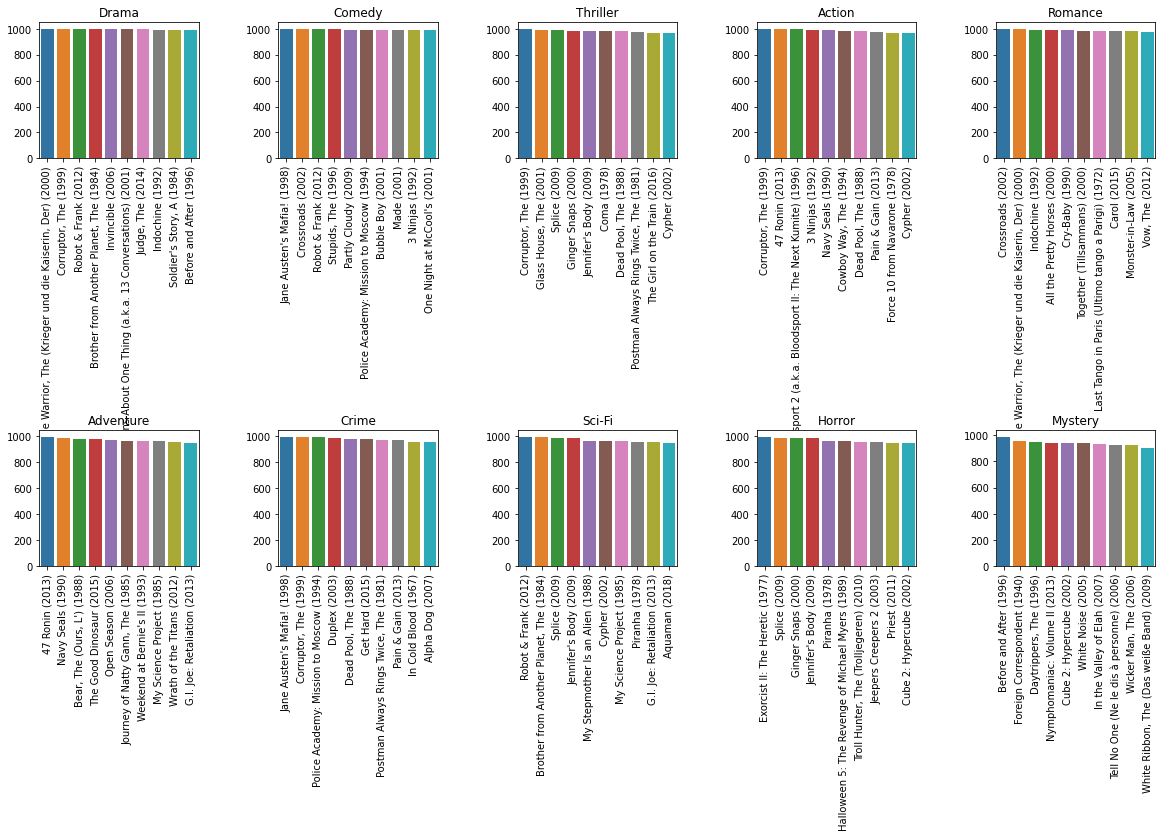

In [26]:
# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
top_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Sci-Fi', 'Horror', 'Mystery']
top_movies = movies[movies['genres'].str.contains('|'.join(top_genres))]
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
top_movies = top_movies.sort_values('rating', ascending=False).head(10)
top_movies

# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
# create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# plot the top 10 movies in terms of number of ratings received for each genre in each subplot
for i, genre in enumerate(top_genres):
    top_movies = movies[movies['genres'].str.contains(genre)]
    top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
    top_movies = top_movies.sort_values('rating', ascending=False).head(10)
    sns.barplot(x='title', y='rating', data=top_movies, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(genre)
    axes[i//5, i%5].set_xlabel('')
    axes[i//5, i%5].set_ylabel('')
    axes[i//5, i%5].tick_params(axis='x', labelrotation=90)
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

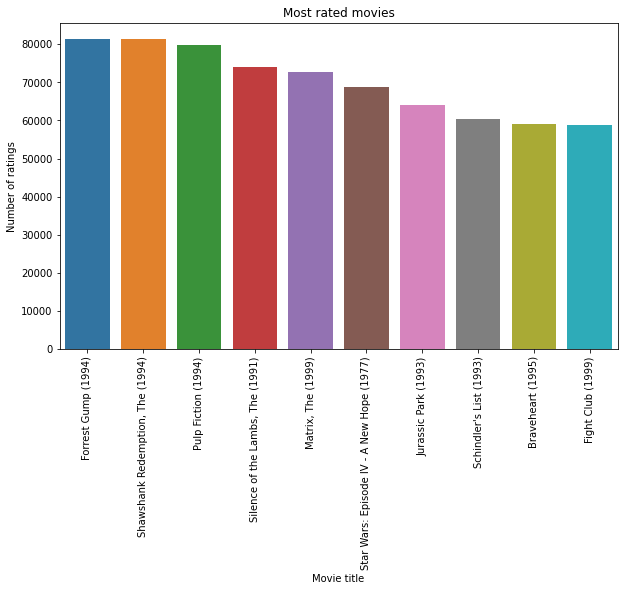

   movieId  rating                                      title  \
0      356   81491                        Forrest Gump (1994)   
1      318   81482           Shawshank Redemption, The (1994)   
2      296   79672                        Pulp Fiction (1994)   
3      593   74127           Silence of the Lambs, The (1991)   
4     2571   72674                         Matrix, The (1999)   
5      260   68717  Star Wars: Episode IV - A New Hope (1977)   
6      480   64144                       Jurassic Park (1993)   
7      527   60411                    Schindler's List (1993)   
8      110   59184                          Braveheart (1995)   
9     2959   58773                          Fight Club (1999)   

                             genres  num_genres  
0          Comedy|Drama|Romance|War           4  
1                       Crime|Drama           2  
2       Comedy|Crime|Drama|Thriller           4  
3             Crime|Horror|Thriller           3  
4            Action|Sci-Fi|Thrille

In [27]:
# plot the most rated movies
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_movie = ratings_per_movie.reset_index()
ratings_per_movie = ratings_per_movie.merge(movies, on='movieId', how='inner')
ratings_per_movie

# plot the most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='rating', data=ratings_per_movie[0:10])
plt.xlabel('Movie title')
plt.ylabel('Number of ratings')
plt.title('Most rated movies')
plt.xticks(rotation=90)
plt.show()

print(ratings_per_movie[0:10])


### Some light data cleaning

In [28]:
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_user = ratings.groupby('userId').count()['rating'].sort_values(ascending=False)

In [29]:
# clean the data
# remove movies with less than 20 ratings
min_movie_ratings = 20
filter_movies = ratings_per_movie > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# remove users who have given less than 10 ratings
min_user_ratings = 20
filter_users = ratings_per_user > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# filter data
ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(25000095, 5)
The new data frame shape:	(24712388, 5)


In [30]:
# # create a user-movie matrix
# # Not efficient for large datasets
# ratings_matrix = ratings_new.pivot(index='userId', columns='movieId', values='rating').fillna(0)
# ratings_matrix.head()

# # create a sparse matrix
# from scipy.sparse import csr_matrix

# # create a sparse matrix
# ratings_matrix_sparse = csr_matrix(ratings_matrix.values)

In [31]:
ratings_new

,userId,movieId,rating,timestamp,datetime
0,1,296,5.0,1147880044,2006-05-17 15:34:04
1,1,306,3.5,1147868817,2006-05-17 12:26:57
2,1,307,5.0,1147868828,2006-05-17 12:27:08
3,1,665,5.0,1147878820,2006-05-17 15:13:40
4,1,899,3.5,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
25000090,162541,50872,4.5,1240953372,2009-04-28 21:16:12
25000091,162541,55768,2.5,1240951998,2009-04-28 20:53:18
25000092,162541,56176,2.0,1240950697,2009-04-28 20:31:37
25000093,162541,58559,4.0,1240953434,2009-04-28 21:17:14


In [32]:
# count the number of unique movies and users
n_movies = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()
print('Number of unique movies: {}'.format(n_movies))
print('Number of unique users: {}'.format(n_users))

Number of unique movies: 18130
Number of unique users: 157930


In [33]:
# print(ratings_matrix_sparse)

In [34]:
movies_new = movies[movies['movieId'].isin(ratings_new['movieId'].unique())]

In [35]:
movies_new

,movieId,title,genres,num_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,3
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
61753,206805,In the Shadow of the Moon (2019),Crime|Mystery|Sci-Fi,3
61770,206845,The Laundromat (2019),Comedy|Crime|Drama,3
61935,207309,Fractured (2019),Thriller,1
61967,207405,Doctor Sleep (2019),Horror,1


In [36]:
# see which movieIds in ratings_new have the highest number of views
ratings_per_movie = ratings_new.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie.sort_values(ascending=False)
ratings_per_movie

movieId
356       80823
318       80530
296       79000
593       73486
2571      72197
          ...  
117322       21
1842         20
3009         20
86646        20
4258         20
Name: rating, Length: 18130, dtype: int64

In [37]:
# The most popular movies
top_movies = movies[movies['movieId'].isin(ratings_per_movie.sort_values(ascending=False).head(10).index)]
# create a column with the number of ratings, num_ratings for each movie
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner').rename(columns={'rating': 'num_ratings'})
top_movies

,movieId,title,genres,num_genres,num_ratings
0,110,Braveheart (1995),Action|Drama|War,3,58838
1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3,68171
2,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,79000
3,318,"Shawshank Redemption, The (1994)",Crime|Drama,2,80530
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4,80823
5,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4,63757
6,527,Schindler's List (1993),Drama|War,2,59937
7,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,3,73486
8,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,3,72197
9,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4,58376


In [38]:
# see which user has the highest number of ratings
ratings_per_user.sort_values(ascending=False)

userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
135032       20
51779        20
135012       20
135005       20
36207        20
Name: rating, Length: 162541, dtype: int64

In [39]:
# merge ratings_new and movies_new on movieId
df = ratings_new.merge(movies_new, on='movieId', how='inner')

In [40]:
df

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,1,296,5.0,1147880044,2006-05-17 15:34:04,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
1,3,296,5.0,1439474476,2015-08-13 14:01:16,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
2,4,296,4.0,1573938898,2019-11-16 21:14:58,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
3,5,296,4.0,830786155,1996-04-29 13:55:55,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
4,7,296,4.0,835444730,1996-06-22 11:58:50,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
...,...,...,...,...,...,...,...,...
24712383,141938,6274,2.0,1538188120,2018-09-29 02:28:40,Physical Evidence (1989),Crime|Thriller,2
24712384,142806,6274,3.0,1101784298,2004-11-30 03:11:38,Physical Evidence (1989),Crime|Thriller,2
24712385,148790,6274,1.0,1144764167,2006-04-11 14:02:47,Physical Evidence (1989),Crime|Thriller,2
24712386,160671,6274,3.5,1200461976,2008-01-16 05:39:36,Physical Evidence (1989),Crime|Thriller,2


In [41]:
# create a mapping that resets the userId index to start from 0 and return the dictionary of the form {new_userId: old_userId} and update the dataframe
new_userId = {new: old for old, new in enumerate(ratings_new['userId'].unique())}
ratings_new['userId'] = ratings_new['userId'].map(new_userId)

# create a mapping that resets the movieId index to start from 0 and return the dictionary of the form {new_movieId: old_movieId} and update the dataframe
new_movieId = {new: old for old, new in enumerate(movies_new['movieId'].unique())}
movies_new['movieId'] = movies_new['movieId'].map(new_movieId)

# update ratings_new with the movie mappings
ratings_new['movieId'] = ratings_new['movieId'].map(new_movieId)

# update df with the mappings
df['userId'] = df['userId'].map(new_userId)
df['movieId'] = df['movieId'].map(new_movieId)


<ipython-input-41-afd5bc0158fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_new['userId'] = ratings_new['userId'].map(new_userId)
<ipython-input-41-afd5bc0158fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['movieId'] = movies_new['movieId'].map(new_movieId)
<ipython-input-41-afd5bc0158fb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [42]:
# show only userID=0

ratings_new[ratings_new['userId'] == 0]

,userId,movieId,rating,timestamp,datetime
0,0,289,5.0,1147880044,2006-05-17 15:34:04
1,0,299,3.5,1147868817,2006-05-17 12:26:57
2,0,300,5.0,1147868828,2006-05-17 12:27:08
3,0,641,5.0,1147878820,2006-05-17 15:13:40
4,0,859,3.5,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
65,0,8447,3.0,1147879774,2006-05-17 15:29:34
66,0,8456,4.5,1147879365,2006-05-17 15:22:45
67,0,8568,3.0,1147869115,2006-05-17 12:31:55
68,0,8840,3.5,1147877610,2006-05-17 14:53:30


In [43]:
df

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,0,289,5.0,1147880044,2006-05-17 15:34:04,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
1,2,289,5.0,1439474476,2015-08-13 14:01:16,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
2,3,289,4.0,1573938898,2019-11-16 21:14:58,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
3,4,289,4.0,830786155,1996-04-29 13:55:55,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
4,6,289,4.0,835444730,1996-06-22 11:58:50,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
...,...,...,...,...,...,...,...,...
24712383,137909,5924,2.0,1538188120,2018-09-29 02:28:40,Physical Evidence (1989),Crime|Thriller,2
24712384,138744,5924,3.0,1101784298,2004-11-30 03:11:38,Physical Evidence (1989),Crime|Thriller,2
24712385,144548,5924,1.0,1144764167,2006-04-11 14:02:47,Physical Evidence (1989),Crime|Thriller,2
24712386,156106,5924,3.5,1200461976,2008-01-16 05:39:36,Physical Evidence (1989),Crime|Thriller,2


In [44]:
# show movies with movieId=0

movies_new[movies_new['movieId'] == 0]

,movieId,title,genres,num_genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5


In [45]:
# Check the number of users in the dataset remains unchanged after the mapping
n_users - ratings_new['userId'].nunique()

0

In [46]:
# Check the number of movies in the dataset remains unchanged after the mapping
n_movies - ratings_new['movieId'].nunique()

0

In [47]:
# check that the mapping is correct
ratings_new

,userId,movieId,rating,timestamp,datetime
0,0,289,5.0,1147880044,2006-05-17 15:34:04
1,0,299,3.5,1147868817,2006-05-17 12:26:57
2,0,300,5.0,1147868828,2006-05-17 12:27:08
3,0,641,5.0,1147878820,2006-05-17 15:13:40
4,0,859,3.5,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
25000090,157929,10065,4.5,1240953372,2009-04-28 21:16:12
25000091,157929,10479,2.5,1240951998,2009-04-28 20:53:18
25000092,157929,10516,2.0,1240950697,2009-04-28 20:31:37
25000093,157929,10683,4.0,1240953434,2009-04-28 21:17:14


In [48]:
movies_new

,movieId,title,genres,num_genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,1,Jumanji (1995),Adventure|Children|Fantasy,3
2,2,Grumpier Old Men (1995),Comedy|Romance,2
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,4,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
61753,18125,In the Shadow of the Moon (2019),Crime|Mystery|Sci-Fi,3
61770,18126,The Laundromat (2019),Comedy|Crime|Drama,3
61935,18127,Fractured (2019),Thriller,1
61967,18128,Doctor Sleep (2019),Horror,1


In [49]:
# check the dictionary of the form {new_userId: old_userId}
new_userId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 52: 50,
 53: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62,
 65: 63,
 66: 64,
 67: 65,
 68: 66,
 69: 67,
 70: 68,
 71: 69,
 72: 70,
 73: 71,
 74: 72,
 75: 73,
 76: 74,
 77: 75,
 78: 76,
 79: 77,
 80: 78,
 81: 79,
 82: 80,
 83: 81,
 84: 82,
 85: 83,
 86: 84,
 87: 85,
 88: 86,
 89: 87,
 90: 88,
 91: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 109: 107,
 110: 108,
 111: 109,
 112: 1

In [50]:
#check that the length of the dictionary is equal to the number of unique users
len(new_userId) == n_users

True

In [51]:
# check the dictionary of the form {new_movieId: old_movieId}
new_movieId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 110: 107,
 111: 108,
 112: 109,
 113: 1

In [52]:
# check that the length of the dictionary is equal to the number of unique movies
len(new_movieId) == n_movies

True

In [53]:
# check the type of the userId column
ratings_new['userId'].dtype


dtype('int64')

In [54]:
# from ratings_new, create a users list where each element is a tuple of the form (userId, movieId, rating)
# select only the columns userId, movieId, rating and make sure that the values are of type int, int, float
users = ratings_new[['userId', 'movieId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
users = [(int(user[0]), int(user[1]), user[2]) for user in users]
users



[(0, 289, 5.0),
 (0, 299, 3.5),
 (0, 300, 5.0),
 (0, 641, 5.0),
 (0, 859, 3.5),
 (0, 1040, 4.0),
 (0, 1120, 3.5),
 (0, 1159, 3.5),
 (0, 1178, 5.0),
 (0, 1190, 4.0),
 (0, 1200, 3.5),
 (0, 1556, 4.0),
 (0, 1868, 2.5),
 (0, 1869, 2.5),
 (0, 1925, 2.5),
 (0, 2017, 3.5),
 (0, 2196, 4.5),
 (0, 2412, 4.0),
 (0, 2467, 5.0),
 (0, 2526, 5.0),
 (0, 2676, 4.5),
 (0, 3241, 4.0),
 (0, 3353, 5.0),
 (0, 3716, 5.0),
 (0, 3906, 5.0),
 (0, 4065, 3.0),
 (0, 4080, 5.0),
 (0, 4173, 3.0),
 (0, 4449, 4.0),
 (0, 4707, 4.5),
 (0, 4876, 4.0),
 (0, 4991, 0.5),
 (0, 5380, 2.0),
 (0, 5457, 5.0),
 (0, 5562, 4.0),
 (0, 5591, 3.0),
 (0, 5628, 4.0),
 (0, 5688, 5.0),
 (0, 6008, 4.5),
 (0, 6014, 4.0),
 (0, 6158, 3.5),
 (0, 6306, 5.0),
 (0, 6525, 3.5),
 (0, 6770, 4.0),
 (0, 6794, 4.5),
 (0, 6870, 2.0),
 (0, 6874, 3.5),
 (0, 6878, 3.5),
 (0, 6908, 5.0),
 (0, 6911, 4.0),
 (0, 7115, 2.5),
 (0, 7180, 3.0),
 (0, 7181, 2.5),
 (0, 7182, 2.5),
 (0, 7183, 4.5),
 (0, 7224, 3.5),
 (0, 7278, 5.0),
 (0, 7342, 5.0),
 (0, 7353, 4.0),
 (

In [55]:
# from ratings_new, create an items list where each element is a tuple of the form (movieId, userId, rating)
# select only the columns movieId, userId, rating
movies = ratings_new.sort_values('movieId')[['movieId', 'userId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
movies = [(int(movie[0]), int(movie[1]), movie[2]) for movie in movies]
movies

[(0, 75298, 4.0),
 (0, 136792, 4.5),
 (0, 136790, 4.0),
 (0, 103199, 3.5),
 (0, 151966, 2.5),
 (0, 56121, 3.0),
 (0, 25338, 4.0),
 (0, 85847, 4.0),
 (0, 25342, 3.5),
 (0, 56122, 5.0),
 (0, 121949, 4.0),
 (0, 136787, 5.0),
 (0, 113416, 4.0),
 (0, 9234, 4.0),
 (0, 56125, 4.0),
 (0, 151968, 4.0),
 (0, 56126, 4.0),
 (0, 151967, 1.5),
 (0, 85852, 4.0),
 (0, 56118, 3.0),
 (0, 56117, 4.5),
 (0, 103186, 4.0),
 (0, 136801, 3.5),
 (0, 56113, 4.0),
 (0, 136800, 2.5),
 (0, 56114, 5.0),
 (0, 56115, 1.0),
 (0, 136798, 3.5),
 (0, 611, 4.0),
 (0, 103187, 4.0),
 (0, 103189, 5.0),
 (0, 113423, 4.0),
 (0, 25345, 1.5),
 (0, 151964, 5.0),
 (0, 136796, 3.0),
 (0, 103194, 3.5),
 (0, 85858, 4.0),
 (0, 11882, 2.5),
 (0, 103204, 4.0),
 (0, 103184, 3.5),
 (0, 56129, 3.0),
 (0, 56130, 3.0),
 (0, 56142, 3.0),
 (0, 103208, 4.0),
 (0, 85830, 4.0),
 (0, 121950, 5.0),
 (0, 136775, 4.0),
 (0, 25327, 3.0),
 (0, 136774, 5.0),
 (0, 136779, 4.0),
 (0, 56146, 4.5),
 (0, 25324, 4.0),
 (0, 56154, 4.5),
 (0, 85829, 4.0),
 (0, 

In [56]:
# # create a dictionary of the form {userId: [(movieId, rating), (movieId, rating), ...]}
# from collections import defaultdict
# user_ratings = defaultdict(list)
# for user, movie, rating in users:
#     user_ratings[user].append((movie, rating))
# user_ratings

# Iterative Alternating Least Squares (IALS)

In [162]:
# train biases for users and movies

# Hyperparameters
num_factors = 1000
lambda_value = 0.1
num_iterations = 50
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

In [58]:
# loop through the number of iterations
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    for user, movie, rating in users:
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
        user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
    # loop through each user-movie pair and calculate item biases
    for movie, user, rating in movies: 
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
        item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    rmse = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users]))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    loglog = np.sum([np.log(1 / (1 + np.exp(-(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))))) for user, movie, rating in users])
    LOGLOG.append(loglog)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')

Iteration: 0 | Root Mean Squared Error: 0.9335841439690891 | Log Likelihood: -918689.6069092969
Iteration: 1 | Root Mean Squared Error: 0.9193570716451988 | Log Likelihood: -925876.2213931833
Iteration: 2 | Root Mean Squared Error: 0.9179929452048275 | Log Likelihood: -942493.1849955246
Iteration: 3 | Root Mean Squared Error: 0.9041753203820464 | Log Likelihood: -962635.0477933272
Iteration: 4 | Root Mean Squared Error: 0.8945907012325867 | Log Likelihood: -983282.0466610524
Iteration: 5 | Root Mean Squared Error: 0.8867779674643533 | Log Likelihood: -995759.430980215
Iteration: 6 | Root Mean Squared Error: 0.879579186470456 | Log Likelihood: -1007923.8320304207
Iteration: 7 | Root Mean Squared Error: 0.8757074232678169 | Log Likelihood: -1017562.4307771908
Iteration: 8 | Root Mean Squared Error: 0.8739904336923808 | Log Likelihood: -1024981.7026320398
Iteration: 9 | Root Mean Squared Error: 0.8743171392006374 | Log Likelihood: -1030685.190803113
Iteration: 10 | Root Mean Squared Error

In [59]:
# calculate the predictions
predictions = np.zeros((n_users, n_items))
for user in range(n_users):
    for movie in range(n_items):
        predictions[user, movie] = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])


In [60]:
# save the user biases, item biases, user factors and item factors
np.save('../data/user_bias.npy', user_bias)
np.save('../data/item_bias.npy', item_bias)
np.save('../data/user_factors.npy', user_factors)
np.save('../data/item_factors.npy', item_factors)

# save the predictions
np.save('../data/predictions.npy', predictions)

In [68]:
# get the predictions for user 0
predictions[0]

array([3.51233039, 3.08166769, 2.86539204, ..., 3.26542212, 3.86120305,
       3.19012868])

In [69]:
# get the actual ratings for user 0
ratings_new[ratings_new['userId'] == 0]

,userId,movieId,rating,timestamp,datetime
0,0,289,5.0,1147880044,2006-05-17 15:34:04
1,0,299,3.5,1147868817,2006-05-17 12:26:57
2,0,300,5.0,1147868828,2006-05-17 12:27:08
3,0,641,5.0,1147878820,2006-05-17 15:13:40
4,0,859,3.5,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
65,0,8447,3.0,1147879774,2006-05-17 15:29:34
66,0,8456,4.5,1147879365,2006-05-17 15:22:45
67,0,8568,3.0,1147869115,2006-05-17 12:31:55
68,0,8840,3.5,1147877610,2006-05-17 14:53:30


In [332]:
# scale the log likelihood
loglog = np.array(LOGLOG)
loglog = (loglog - loglog.min()) / (loglog.max() - loglog.min())


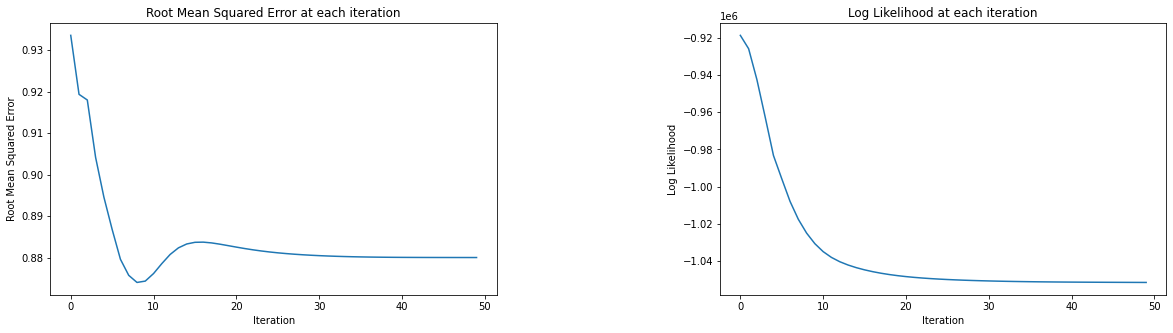

In [63]:
# create a subplot with 2 columns and 1 row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# plot the root mean squared error at each iteration
axes[0].plot(range(num_iterations), RMSE)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].set_title('Root Mean Squared Error at each iteration')
# plot the log likelihood at each iteration
axes[1].plot(range(num_iterations)[:], LOGLOG[:])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log Likelihood')
axes[1].set_title('Log Likelihood at each iteration')
# set the scales of the log likelihood plot to be on a log scale
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

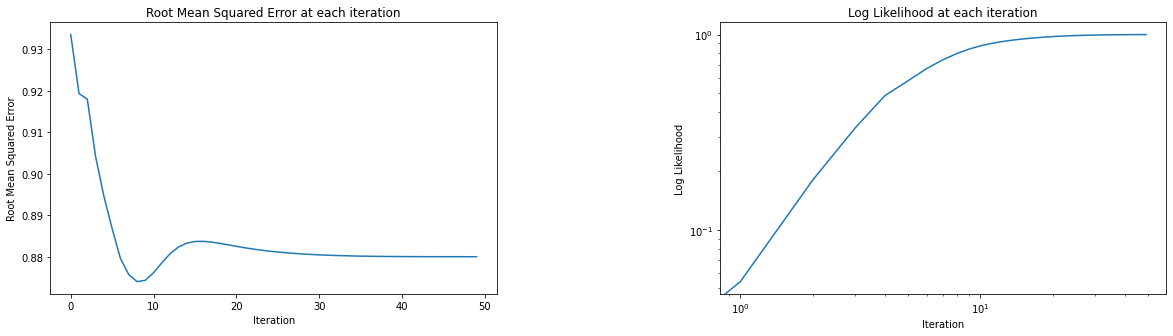

In [67]:
# create a subplot with 2 columns and 1 row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# plot the root mean squared error at each iteration
axes[0].plot(range(num_iterations), RMSE)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].set_title('Root Mean Squared Error at each iteration')
# plot the log likelihood at each iteration
# invert the log likelihood
loglog = np.array(LOGLOG)
loglog = (loglog - loglog.min()) / (loglog.max() - loglog.min())
loglog = 1 - loglog
axes[1].plot(range(num_iterations)[:], loglog[:])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log Likelihood')
axes[1].set_title('Log Likelihood at each iteration')
# set the scales of the log likelihood plot to be on a log scale
axes[1].set_xscale('log')
axes[1].set_yscale('log')
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

### Parallelization

In [337]:
import multiprocessing

multiprocessing.cpu_count()

8

In [159]:
def calculate_user_biases(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
    user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])

def calculate_item_biases(movie, user, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
    item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

def calculate_rmse(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return (prediction - rating) ** 2

def calculate_loglikelihood(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return np.log(1 / (1 + np.exp(-prediction)))

In [160]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)

    for _ in range(num_iterations):
        # Calculate user biases in parallel
        user_res = pool.starmap(calculate_user_biases, users)
        user_para = user_res.get()

        # Calculate item biases in parallel
        pool.starmap(calculate_item_biases, movies)

        # Calculate RMSE in parallel
        rmse_results = pool.starmap(calculate_rmse, users)
        rmse = np.sqrt(np.mean(rmse_results))
        RMSE.append(rmse)

        # Calculate log likelihood in parallel
        loglik_results = pool.starmap(calculate_loglikelihood, users)
        loglik = np.sum(loglik_results)
        LOGLOG.append(loglik)
        
        print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')


    pool.close()
    pool.join()


NameError: name 'multiprocessing' is not defined

In [161]:
# parrallelize the code using multiprocessing
from multiprocessing import Pool

# Hyperparameters
num_factors = 1000
lambda_value = 0.1
num_iterations = 50
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

# loop through the number of iterations
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    with Pool(4) as p1:
        p1.starmap(calculate_user_biases, users)

    # loop through each user-movie pair and calculate item biases
    with Pool(4) as p2:
        p2.starmap(calculate_item_biases, movies)

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    with Pool(4) as p3:
        rmse_results = p3.starmap(calculate_rmse, users)
    rmse = np.sqrt(np.mean(rmse_results))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    with Pool(4) as p4:
        loglik_results = p4.starmap(calculate_loglikelihood, users)
    loglik = np.sum(loglik_results)
    LOGLOG.append(loglik)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')



KeyboardInterrupt: 

In [56]:
# Hyperparameters
num_factors = 100
lambda_value = 0.1
num_iterations = 15
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

In [57]:
# loop through the number of iterations
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    for user, movie, rating in users:
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
        user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
    # loop through each user-movie pair and calculate item biases
    for movie, user, rating in movies: 
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
        item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    rmse = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users]))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    loglog = np.sum([np.log(1 / (1 + np.exp(-(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))))) for user, movie, rating in users])
    LOGLOG.append(loglog)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')

Iteration: 0 | Root Mean Squared Error: 0.9334151063130033 | Log Likelihood: -918691.7063129934
Iteration: 1 | Root Mean Squared Error: 0.9185186321288809 | Log Likelihood: -925900.5437677925
Iteration: 2 | Root Mean Squared Error: 0.9088878340361914 | Log Likelihood: -944242.009282717
Iteration: 3 | Root Mean Squared Error: 0.8923186944296156 | Log Likelihood: -969578.0033015939
Iteration: 4 | Root Mean Squared Error: 0.8827349943284307 | Log Likelihood: -984766.1169112177
Iteration: 5 | Root Mean Squared Error: 0.875058279004028 | Log Likelihood: -998716.2833260953
Iteration: 6 | Root Mean Squared Error: 0.8709135895880867 | Log Likelihood: -1009759.5242252201
Iteration: 7 | Root Mean Squared Error: 0.8693798486038471 | Log Likelihood: -1018403.4003449035
Iteration: 8 | Root Mean Squared Error: 0.8700542632729436 | Log Likelihood: -1025108.4169601732
Iteration: 9 | Root Mean Squared Error: 0.8722134250312095 | Log Likelihood: -1030161.461569375
Iteration: 10 | Root Mean Squared Error

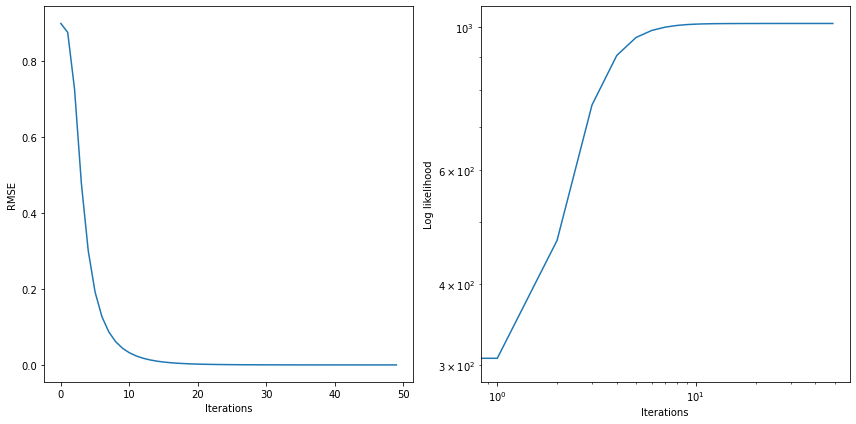

In [ ]:
# create a subplot of 1 row and 3 columns
plt.figure(figsize=(12, 6))

# plot the RMSE
plt.subplot(1, 2, 1)
plt.plot(range(num_iterations), training_errors)
plt.xlabel('Iterations')
plt.ylabel('RMSE')

# plot the log likelihood
plt.subplot(1, 2, 2)
plt.plot(range(num_iterations), log_errors)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')
plt.yscale('log')
plt.xscale('log')


# adjust the subplots so that the plots don't overlap
plt.tight_layout()
plt.show()

In [72]:
# make predictions for user 0
user_0_predictions = user_bias[0] + item_bias + user_factors[0, :].dot(item_factors.T)

# print the predicted ratings for user 0
user_0_predictions

# print the actual ratings for user 0
top_0_movies = ratings_new[ratings_new['userId'] == 0].sort_values('rating', ascending=False)

# return the movie titles of top_0_movies
top_0_movies = movies_new[movies_new['movieId'].isin(top_0_movies['movieId'])]

In [67]:
user_0_predictions

array([4.        , 3.27971375, 4.        , ..., 4.91664159, 5.58303736,
       5.39850958])

In [73]:
top_0_movies

,movieId,title,genres,num_genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,2,Grumpier Old Men (1995),Comedy|Romance,2
5,4,Heat (1995),Action|Crime|Thriller,3
43,23,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2
46,25,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3
...,...,...,...,...
2765,749,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller,4
2798,752,Big Trouble in Little China (1986),Action|Adventure|Comedy|Fantasy,4
2836,759,X-Men (2000),Action|Adventure|Sci-Fi,3
2847,761,What About Bob? (1991),Comedy,1


In [69]:
# get the top 10 movie recommendations for user 0
top_10_recommendations = np.argsort(user_0_predictions)[::-1][0:10]
# return the movie titles of the top 10 recommendations
movies_new[movies_new['movieId'].isin(top_10_recommendations)]['title']

311                        Crow, The (1994)
935                 Harold and Maude (1971)
1390                           Mulan (1998)
1404    There's Something About Mary (1998)
3640               Beautiful Mind, A (2001)
6422                        Hot Fuzz (2007)
6609               American Gangster (2007)
7802                    Intouchables (2011)
8695       Guardians of the Galaxy 2 (2017)
8900                      Inside Out (2015)
Name: title, dtype: object

# Digression - Experiment using cosine similarity.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Filling the sparse matrix with zeros is not a good idea. We can use the mean of the ratings as a proxy for the missing values. This is a simple and effective way to fill in the missing values. It will also help us to avoid the problem of overfitting. We will use the `sklearn` library to calculate the mean of the ratings.

In [54]:
# create a function that standardizes each row (user)
def standardize(row):
    new_row = (row - row.mean())/(row.max() - row.min())
    return new_row

# create a new matrix with standardized values
ratings_std = ratings_matrix.apply(standardize)

# calculate the cosine similarity between users
user_similarity = cosine_similarity(ratings_std)

# calculate the cosine similarity between movies
# we take the transpose of the matrix to get the similarity between movies
item_similarity = cosine_similarity(ratings_std.T)
        

In [ ]:
# create a function that returns the most similar users
def get_similar_users(user_id, user_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # create a Series with the similarity scores in descending order
    # drop the user's own similarity score
    sim_scores = pd.Series(user_similarity[idx]).sort_values(ascending=False)
    
    # get the user indices
    user_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar users
    top_users = sim_scores.iloc[1:11].index
    
    # print the user_id and the 10 most similar users
    print('The 10 most similar users for User {} are:)'.format(user_id))
    for i in top_users:
        print(ratings_matrix.index[i])

In [55]:
get_similar_users(1, user_similarity)

The 10 most similar users for User 1 are:)
313
266
57
469
368
452
19
597
217
135


In [56]:
# create a function that returns the most similar movies
def get_similar_movies(movie_id, item_similarity):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx]).sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} are:)'.format(movie_id))
    for i in top_movies:
        print(ratings_matrix.columns[i])

In [57]:
get_similar_movies(1, item_similarity)

The 10 most similar movies for Movie 1 are:)
3114
1265
780
1073
648
788
2355
364
34
4886


In [93]:
# print the movie_id and the 10 most similar movies and their similarity scores with movie titles
def get_similar_movies(movie_id, item_similarity, user_rating):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx])
    # scale the similarity scores so that user rating can be considered
    sim_scores = sim_scores * (user_rating-2.5)
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} {} are:)'.format(movie_id, movies[movies['movieId'] == ratings_matrix.columns[idx]]['title'].values[0]))
    for i in top_movies:
        print(ratings_matrix.columns[i], sim_scores[i], movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])
        
get_similar_movies(356, item_similarity,4)

The 10 most similar movies for Movie 356 Forrest Gump (1994) are:)
480 0.6804485215599689 Jurassic Park (1993)
500 0.6606902061812354 Mrs. Doubtfire (1993)
318 0.6167698303340495 Shawshank Redemption, The (1994)
150 0.5855610032337975 Apollo 13 (1995)
597 0.5852691787933728 Pretty Woman (1990)
110 0.5614109303785232 Braveheart (1995)
296 0.5606638672059776 Pulp Fiction (1994)
364 0.537211883052519 Lion King, The (1994)
377 0.5221630911178504 Speed (1994)
586 0.5134442777352655 Home Alone (1990)


In [110]:
# create a function that takes in a user list of movies and ratings, and returns the top 10 recommended movies for that user
def get_recommendations(user_id, user_similarity, item_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # get the user ratings
    user_ratings = ratings_matrix.iloc[idx].values
    
    # create a Series with the movie titles
    movie_titles = ratings_matrix.columns
    
    # create a list to store the similarity scores
    sim_scores = []
    
    # for each movie
    for i in range(len(user_ratings)):
        # if the user has rated the movie
        if user_ratings[i] > 0:
            # for each item in the item_similarity array
            for j in range(len(item_similarity[i])):
                # calculate the similarity score
                sim_scores.append((item_similarity[i][j], movie_titles[j]))
    
    # sort the scores
    sim_scores = sorted(sim_scores, key=lambda x: x[0], reverse=True)
    
    # get the scores of the 10 most similar movies
    sim_scores = sim_scores[:10]
    
    # get the movie indices
    movie_indices = [i[1] for i in sim_scores]


    # print out the top 10 movies that the user has watched with movie titles and ratings
    print('The top 10 movies that User {} has watched are:'.format(user_id))
    for i in ratings_matrix.iloc[idx].sort_values(ascending=False)[:10].index:
        print(i, ratings_matrix.iloc[idx][i], movies[movies['movieId'] == i]['title'].values[0])

        


    # print the top 10 most similar movies
    print('\n')
    print('The top 10 recommended movies for User {}  are:'.format(user_id))
    for i in movie_indices:
        print(i, movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])

get_recommendations(524, user_similarity, item_similarity)

The top 10 movies that User 524 has watched are:
150 5.0 Apollo 13 (1995)
1200 5.0 Aliens (1986)
1266 5.0 Unforgiven (1992)
1275 5.0 Highlander (1986)
1278 5.0 Young Frankenstein (1974)
494 5.0 Executive Decision (1996)
457 5.0 Fugitive, The (1993)
1242 5.0 Glory (1989)
1291 5.0 Indiana Jones and the Last Crusade (1989)
1303 5.0 Man Who Would Be King, The (1975)


The top 10 recommended movies for User 524  are:
193 Drop Zone (1994)
1208 Air Force One (1997)
485 Tombstone (1993)
1356 Borrowers, The (1997)
10 American President, The (1995)
6 Sabrina (1995)
445 Poetic Justice (1993)
880 Double Life of Veronique, The (Double Vie de Véronique, La) (1991)
151 Mad Love (1995)
457 Romper Stomper (1992)


8